In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

import eli5
from eli5.sklearn import PermutationImportance

In [2]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
datafix = '../data/datafix.csv'

concat_select = pd.read_csv(datafix)

## 5. Model Training

- 이제 위에서 만든 파생변수들과 정제한 데이터를 기반으로 본격적으로 부동산 실거래가를 예측하는 모델링을 진행하겠습니다.
- 모델링에는 `sklearn`의 `RandomForest`를 이용하도록 하겠습니다.

- 참고 ✅
  - `RandomForest`는 배깅(Bagging)의 일종으로, 학습시키는 데이터 뿐 아니라 특성변수(X)들도 무작위로 선택해 트리를 생성하는 방법입니다.
  - 모델 학습 과정에서 서로 다른 N개의 Tree 생성하고, N개의 Tree에서 발생한 Output을 Voting(범주형, 분류문제)하거나, Average(연속형, 회귀문제)해 최종 Output 생성합니다.
  - 이는 High variance, Low bias 상황에서 분산(Variance) 감소에 도움을 줍니다.

In [3]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1117284, 23) (9272, 23)


In [4]:
dt_test.head(1)

,아파트명,전용면적,계약일,층,건축년도,좌표X,좌표Y,target,구,동,...,평형대,price_increase_rate,동등급,브랜드등급,한강근접여부,학군,closest_subway_distance,closest_bus_distance,기준금리,신축여부
1117284,개포6차우성,8.942595,26,1.609438,1987,127.05721,37.476763,0.0,강남구,개포동,...,소형,5.843381,1,2,2,8학군,619,11345,3.5,0


In [5]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

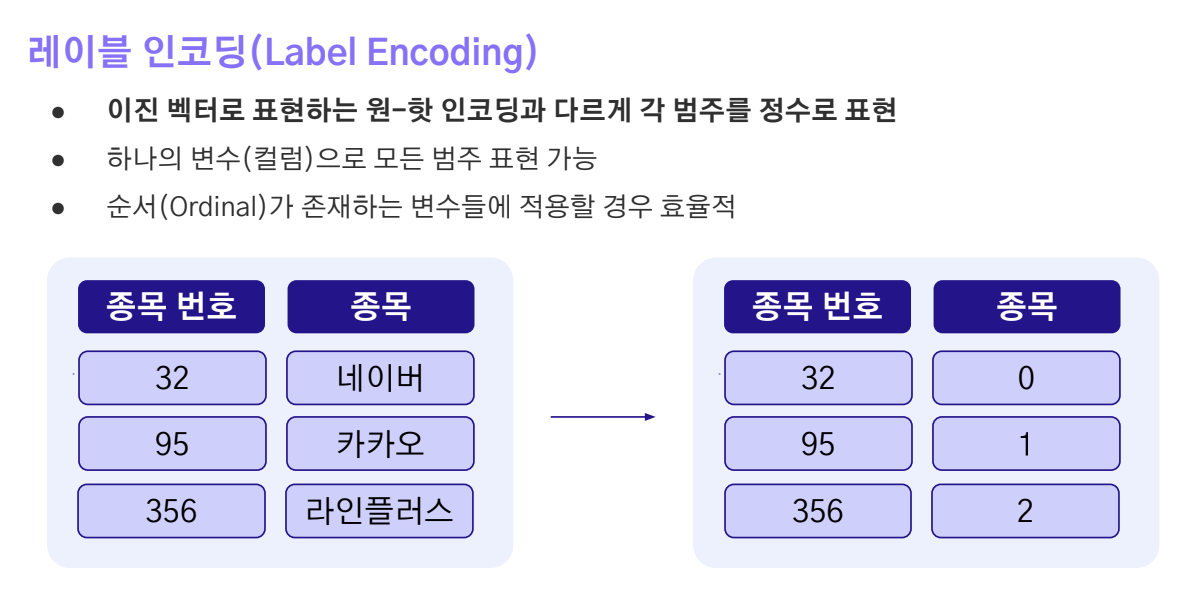

In [6]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', '좌표X', '좌표Y', 'target', '계약년', '계약월', '강남여부', 'price_increase_rate', '동등급', '브랜드등급', '한강근접여부', 'closest_subway_distance', 'closest_bus_distance', '기준금리', '신축여부']
범주형 변수: ['아파트명', '구', '동', '평형대', '학군']


In [7]:
# 범주형 변수에 대한 보간
concat_select[categorical_columns_v2] = concat_select[categorical_columns_v2].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat_select[continuous_columns_v2] = concat_select[continuous_columns_v2].interpolate(method='linear', axis=0)

In [8]:
# EDA에 앞서 결측치를 확인해보겠습니다.
concat_select.isnull().sum()

아파트명                       0
전용면적                       0
계약일                        0
층                          0
건축년도                       0
좌표X                        0
좌표Y                        0
target                     0
is_test                    0
구                          0
동                          0
계약년                        0
계약월                        0
강남여부                       0
평형대                        0
price_increase_rate        0
동등급                        0
브랜드등급                      0
한강근접여부                     0
학군                         0
closest_subway_distance    0
closest_bus_distance       0
기준금리                       0
신축여부                       0
dtype: int64

In [9]:
# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# 범주형 변수에 대해 레이블 인코딩을 적용
for col in tqdm(categorical_columns_v2):
    lbl = LabelEncoder()

    # 학습 데이터와 테스트 데이터를 모두 문자열로 변환하여 처리
    dt_train[col] = dt_train[col].astype(str)
    dt_test[col] = dt_test[col].astype(str)
    
    # 학습 데이터에 대한 레이블 인코딩을 학습 및 변환
    lbl.fit(dt_train[col])
    dt_train[col] = lbl.transform(dt_train[col])
    label_encoders[col] = lbl  # 나중에 후처리를 위해 레이블 인코더 저장
    
    # Test 데이터에서 학습에 없었던 레이블을 추가하는 방식
    unseen_labels = np.setdiff1d(np.unique(dt_test[col]), lbl.classes_)
    
    # 새로운 레이블이 있으면 학습된 클래스에 추가
    if unseen_labels.size > 0:
        new_classes = np.concatenate([lbl.classes_, unseen_labels])
        lbl.classes_ = new_classes
    
    # Test 데이터에 변환을 적용
    dt_test[col] = lbl.transform(dt_test[col])


100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


### 5.2. Model Training
- 위 데이터를 이용해 모델을 train 해보겠습니다. 모델은 XGBoost 이용하겠습니다.
- 마크다운에 RandomForest관련 사항은 삭선표시해두었습니다.

In [10]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [11]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [12]:
# !pip install catboost
from catboost import CatBoostRegressor

model = CatBoostRegressor(iterations=10000,
                              random_seed=42,
                              verbose=100,
                              eval_metric='RMSE')
model.fit(X_train,y_train,eval_set=(X_val,y_val),early_stopping_rounds=50)

Learning rate set to 0.036328
0:	learn: 44653.4037258	test: 44584.7614847	best: 44584.7614847 (0)	total: 75.1ms	remaining: 12m 30s
100:	learn: 17817.4344233	test: 17709.2516515	best: 17709.2516515 (100)	total: 2.42s	remaining: 3m 56s
200:	learn: 15042.5328548	test: 14970.3916685	best: 14970.3916685 (200)	total: 4.79s	remaining: 3m 53s
300:	learn: 13774.2700846	test: 13724.7023406	best: 13724.7023406 (300)	total: 7.16s	remaining: 3m 50s
400:	learn: 12961.9409485	test: 12927.6594678	best: 12927.6594678 (400)	total: 9.53s	remaining: 3m 48s
500:	learn: 12302.0945946	test: 12278.8857998	best: 12278.8857998 (500)	total: 11.9s	remaining: 3m 45s
600:	learn: 11789.1644210	test: 11785.6437094	best: 11785.6437094 (600)	total: 14.3s	remaining: 3m 43s
700:	learn: 11385.0718330	test: 11397.0435939	best: 11397.0435939 (700)	total: 16.7s	remaining: 3m 41s
800:	learn: 11024.7493104	test: 11047.5842997	best: 11047.5842997 (800)	total: 19s	remaining: 3m 38s
900:	learn: 10714.8848209	test: 10753.3800538	b

# 모델 비교
이미 val pred RMSE가 위에 나와 있지만 그래도 보기 편하라고 한번 더 보여드림.

In [13]:
pred = model.predict(X_val)
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 6687.3706613050435


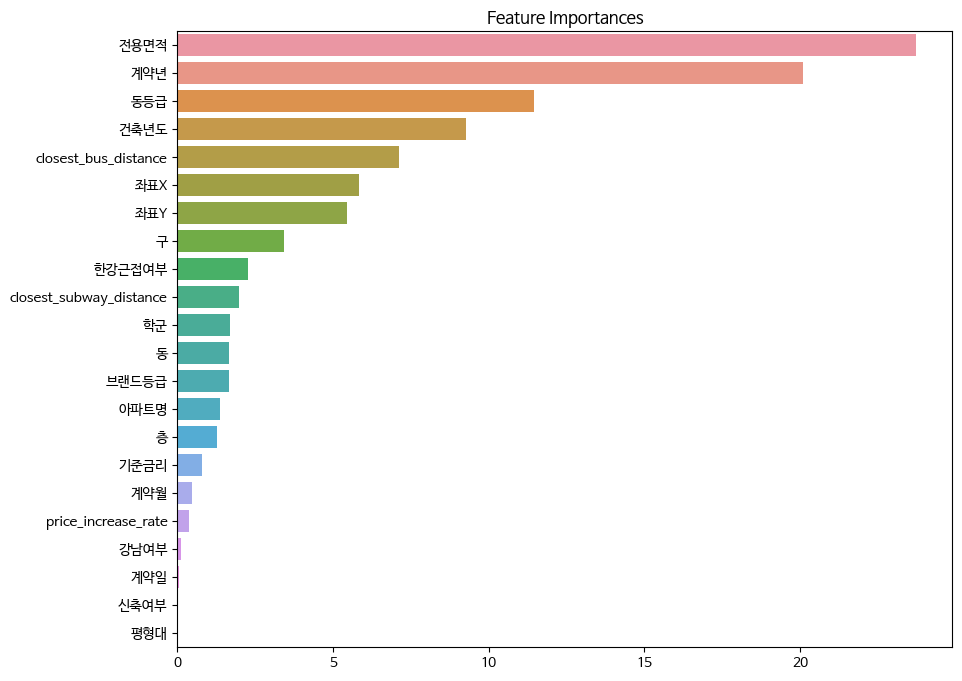

In [14]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [15]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

### 5.3. Feature selection

- 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용해보겠습니다.

In [16]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(model,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist(), top=len(X_val.columns))    # valid data에 대해 적합시킵니다.

Weight,Feature
926202528.0205 ± 4430968.0478,전용면적
896982031.4665 ± 6277370.3015,계약년
257855642.4376 ± 2837419.0173,건축년도
241812796.7489 ± 650923.7735,좌표Y
156705273.0236 ± 1471864.0047,좌표X
144548474.1942 ± 1713869.8927,동등급
131712582.3613 ± 1197829.8571,closest_bus_distance
65545695.7201 ± 551036.7866,구
31248150.0415 ± 70388.9250,closest_subway_distance
30741505.8589 ± 355334.8436,브랜드등급


### 5.4. Valid prediction 분석

- 예측값을 분석해보기 위해 valid prediction을 확인해보겠습니다.

In [17]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

In [18]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [19]:
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [20]:
X_val_sort.head()

,아파트명,전용면적,계약일,층,건축년도,좌표X,좌표Y,구,동,계약년,...,브랜드등급,한강근접여부,학군,closest_subway_distance,closest_bus_distance,기준금리,신축여부,target,pred,error
288227,1847,15.110923,15,1.791759,2019,127.009942,37.531536,20,312,2021,...,2,1,6,635,780,0.75,1,970000.0,545854.057288,1.798998e+11
235897,5924,15.501774,30,1.098612,2011,127.009496,37.536978,20,312,2022,...,2,1,6,635,1081,1.75,0,1100000.0,821118.290561,7.777501e+10
533895,5924,15.609036,31,0.000000,2011,127.009496,37.536978,20,312,2017,...,2,1,6,635,1081,1.25,0,727000.0,479678.723501,6.116781e+10
236287,1847,15.013660,26,1.791759,2019,127.009942,37.531536,20,312,2022,...,2,1,6,635,780,1.75,1,900000.0,652811.930806,6.110194e+10
1000509,4464,15.615697,21,3.610918,2009,126.970685,37.524275,20,235,2009,...,2,2,6,637,876,2.00,0,565000.0,323065.598754,5.853225e+10


- 예측을 잘 하지 못한 top 100개의 데이터와 예측을 잘한 top 100개의 데이터를 비교해보겠습니다.

In [21]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

In [22]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [23]:
display(error_top100.head(5))
display(best_top100.head(1))

,아파트명,전용면적,계약일,층,건축년도,좌표X,좌표Y,구,동,계약년,...,브랜드등급,한강근접여부,학군,closest_subway_distance,closest_bus_distance,기준금리,신축여부,target,pred,error
288227,르가든더메인한남,15.110923,15,1.791759,2019,127.009942,37.531536,용산구,한남동,2021,...,2,1,5학군,635,780,0.75,1,970000.0,545854.057288,1.798998e+11
235897,한남더힐,15.501774,30,1.098612,2011,127.009496,37.536978,용산구,한남동,2022,...,2,1,5학군,635,1081,1.75,0,1100000.0,821118.290561,7.777501e+10
533895,한남더힐,15.609036,31,0.000000,2011,127.009496,37.536978,용산구,한남동,2017,...,2,1,5학군,635,1081,1.25,0,727000.0,479678.723501,6.116781e+10
236287,르가든더메인한남,15.013660,26,1.791759,2019,127.009942,37.531536,용산구,한남동,2022,...,2,1,5학군,635,780,1.75,1,900000.0,652811.930806,6.110194e+10
1000509,용산파크타워,15.615697,21,3.610918,2009,126.970685,37.524275,용산구,용산동5가,2009,...,2,2,5학군,637,876,2.00,0,565000.0,323065.598754,5.853225e+10


,아파트명,전용면적,계약일,층,건축년도,좌표X,좌표Y,구,동,계약년,...,브랜드등급,한강근접여부,학군,closest_subway_distance,closest_bus_distance,기준금리,신축여부,target,pred,error
1089618,상계주공12,6.426508,1,2.079442,1988,127.059319,37.666166,노원구,상계동,2007,...,2,2,4학군,279,4772,4.5,0,11100.0,11101.36033,1.850497


- 이제 분포를 비교해보도록 하겠습니다.

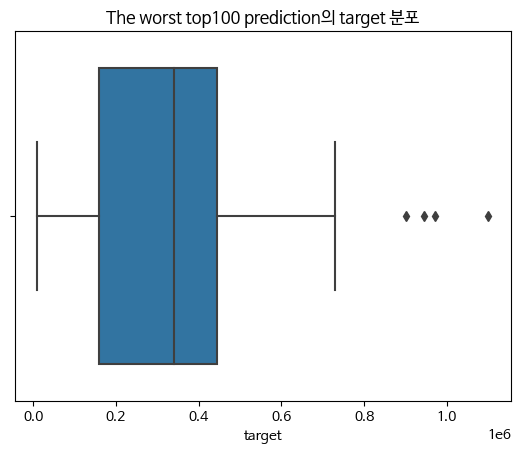

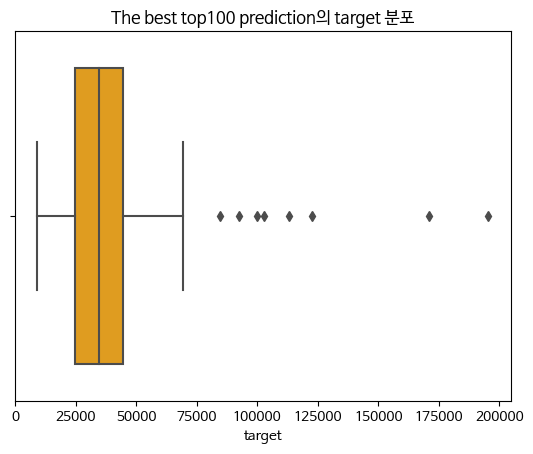

In [24]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

- Taget 분포를 보니 좋은 예측을 보인 top 100개의 data보다 상대적으로 나쁜 예측을 보인 top 100 dataset들이 높은 가격을 보였음을 확인할 수 있습니다. 이에 대한 모델링 및 처리가 필요해보입니다.

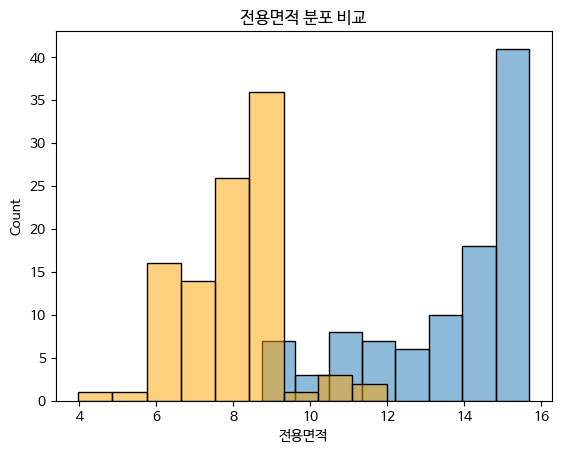

In [25]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

- 전용면적 또한 나쁜 예측을 보인 집들이 더 넓음을 확인할 수 있습니다.

## 6. Inference

In [26]:
dt_test.head(2)      # test dataset에 대한 inference를 진행해보겠습니다.

,아파트명,전용면적,계약일,층,건축년도,좌표X,좌표Y,target,구,동,...,평형대,price_increase_rate,동등급,브랜드등급,한강근접여부,학군,closest_subway_distance,closest_bus_distance,기준금리,신축여부
1117284,327,8.942595,26,1.609438,1987,127.057210,37.476763,0,0,8,...,0,5.843381,1,2,2,9,619,11345,3.5,0
1117285,328,10.402005,15,2.302585,2021,127.056394,37.484892,0,0,8,...,0,5.843381,1,1,2,9,619,11236,3.5,1


In [27]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [28]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

CPU times: user 109 ms, sys: 16 ms, total: 125 ms
Wall time: 15.3 ms


In [29]:
real_test_pred          # 예측값들이 출력됨을 확인할 수 있습니다.

array([202583.45213655, 313046.9498396 , 323322.69235284, ...,
        84493.08290924,  72537.28262068,  71272.07784438])

## 7. Output File Save

In [30]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output_cat.csv', index=False)